In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io 
import keras
from tensorflow.keras.layers.experimental import preprocessing
import os,cv2
from tensorflow.keras.utils import normalize

from skimage.transform import resize
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data volume

It is already cropped and resized. 

In [3]:
with open('/content/drive/MyDrive/FYP_colab/Lung_image_volume.npy', 'rb') as f:
    train_images = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/Lung_mask_volume.npy', 'rb') as f:
    train_masks = np.load(f)

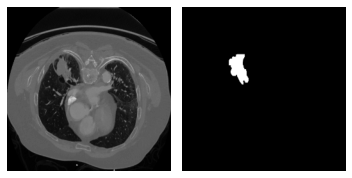

In [4]:
fig,ax = plt.subplots(1,2,figsize=(5,3))

ax[0].imshow(train_images[100,:,:], cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].imshow(train_masks[100,:,:], cmap=plt.cm.gray)
ax[1].axis('off')

plt.tight_layout()
#plt.savefig("../images/mask_bbox.png", bbox_inches="tight")
plt.show()

# Dataset process

In [5]:
image_dataset = np.expand_dims(normalize(train_images, axis=1), 3) # only the images need normalization
mask_dataset = np.expand_dims(train_masks, 3)/255

In [6]:
# Train validation split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, 
                                                    test_size = 0.20, random_state = 0)

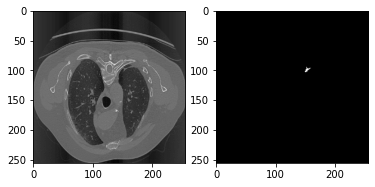

In [ ]:
# Correspondence check
import random 
image_number = random.randint(0,len(X_train)) 
plt.figure()
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256,256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256,256)), cmap='gray')
plt.show()

# Loss

## Jaccard

In [7]:
from tensorflow.keras import backend as K

def jaccard_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  jaccard_coef = (intersection + 1)/ (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)  # 1 is probably used to avoid nan for 0/0 
  return jaccard_coef

def jaccard_loss(y_true,y_pred):
  return 1.0-jaccard_coef(y_true, y_pred)

## Dice loss

In [8]:
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  dice_coef = 2 * (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)
  return dice_coef

def dice_loss(y_true, y_pred):
  return 1.0 - dice_coef(y_true, y_pred)

# Model Implementation
Data augmentation in inserted into the network

In [9]:
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Dropout, Lambda

## Define model

In [10]:
def simple_unet_model(H, W, C):
  inputs = Input((H,W,C))
  s = inputs

  # Contraction path
  c1 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = Dropout(0.1)(c1)
  c1 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = MaxPooling2D((2,2))(c4)

  # Bottleneck
  c5 = Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  # Expansive path
  u6 = Conv2DTranspose(512, (2,2), strides = (2,2), padding = 'same')(c5)
  u6 = concatenate([u6,c4])
  c6 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

  u7 = Conv2DTranspose(256, (2,2), strides = (2,2), padding = 'same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

  u8 = Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

  u9 = Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(c8)
  u9 = concatenate([u9,c1])
  c9 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  outputs = Conv2D(1, (1,1), activation = 'sigmoid')(c9) # Only do binary classification

  model = Model(inputs = [inputs], outputs = [outputs])
#   model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
  # model.compile(optimizer='adam', loss=[jaccard_loss], metrics = [jaccard_coef])
#   model.compile(optimizer='adam', loss=[dice_loss], metrics = [dice_coef])
  # model.summary()

  return model

## Load model

In [11]:
# model takes in 3 parameters H, W, C
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

unet = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS) 

In [12]:
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, jaccard_coef, 'accuracy']) # 

## Train model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

In [ ]:
ckeckpoint_path = "/content/checkpoint/Unet_Lung_batcsize_2_BCE_loss_{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(ckeckpoint_path, monitor='val_loss', verbose=1, save_weights_only=True)

# early_stop = EarlyStopping(monitor='dice_coef', patience = 20, verbose=1)

log_csv = CSVLogger('Unet_batchsize_2_BCE_logs.csv', separator=',', append=False)

# model_dice.load_weights('/content/drive/MyDrive/FYP_colab/204modelcheckpoint/mdoel_dice_loss_05.hdf5')

callbacks = [checkpoint, log_csv]


In [ ]:
history_bce = unet.fit(X_train, y_train, 
                    batch_size = 2,
                    verbose=1,
                    epochs=60,
                    validation_split = 0.2,
                    # shuffle=True, 
                    callbacks = callbacks) 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

h = pd.read_csv('/content/Unet_batchsize_2_BCE_logs.csv')


In [ ]:
fig = plt.figure(figsize=(20,10))

plt.subplot(121)
plt.plot(list(h['epoch'][1:]), list(h['loss'][1:]), label='train loss (BCE)')
plt.plot(list(h['epoch']), list(h['val_loss']), label='val loss (BCE)')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(list(h['epoch']), list(h['dice_coef']), label='train dice score')
plt.plot(list(h['epoch']), list(h['val_dice_coef']), label='val dice score')
plt.grid()
plt.legend()

plt.tight_layout()
#plt.savefig("../images/mask_bbox.png", bbox_inches="tight")

plt.show()

## Evaluation

In [13]:
unet.load_weights('/content/drive/MyDrive/FYP_colab/Lung_Nodule_Segmentation_Project/Unet_weights.hdf5')

In [14]:
y_pred = unet.predict(X_test) # running on the positive test set

In [16]:
with open('/content/drive/MyDrive/FYP_colab/Lung_image_volume_negative.npy', 'rb') as f:
    negative_images = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/Lung_mask_volume_negative.npy', 'rb') as f:
    negative_masks = np.load(f)

X_test_negative = np.expand_dims(negative_images / np.max(train_images), 3) # only the images need normalization
y_test_negative = np.expand_dims(negative_masks, 3)

In [17]:
import numpy as np
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_S_images.npy', 'rb') as f:
    X_test_S = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_S_masks.npy', 'rb') as f:
    y_test_S = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_M_images.npy', 'rb') as f:
    X_test_M = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_M_masks.npy', 'rb') as f:
    y_test_M = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_L_images.npy', 'rb') as f:
    X_test_L = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_L_masks.npy', 'rb') as f:
    y_test_L = np.load(f)

In [18]:
def measure(model, X_test, y_test, X_test_negative, y_test_negative, 
            X_test_S, y_test_S, X_test_M, y_test_M, X_test_L, y_test_L):
    
    y_pred = model.predict(X_test)
    negative_pred = model.predict(X_test_negative)
    y_pred_S = model.predict(X_test_S) # running on the positive test set
    y_pred_M = model.predict(X_test_M) # running on the positive test set
    y_pred_L = model.predict(X_test_L) # running on the positive test set

    y_pred_thresholded = y_pred > 0.5

    # IoU (Jaccard)
    intersection = np.logical_and(y_test, y_pred_thresholded)
    union = np.logical_or(y_test, y_pred_thresholded)
    iou = np.sum(intersection) / np.sum(union)

    # Dice
    y_true_f = y_test.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    dice_coef = 2 * (intersection + 1.0) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1.0)

    # Prec, recall, accu
    precision = np.sum(intersection) / np.sum(y_pred_thresholded)
    recall = np.sum(intersection) / np.sum(y_test)

    corr = np.logical_not(np.logical_xor(y_test, y_pred_thresholded))
    accu = int(np.sum(corr)) / (332 * (256 ** 2))

    # Negative dataset
    negative_pred_thresholded = negative_pred > 0.5
    corrN = np.logical_not(np.logical_xor(y_test_negative, negative_pred_thresholded))
    accuN = int(np.sum(corrN)) / (150 * (256 ** 2))

    # SML dataset
    y_true_Sf = y_test_S.flatten()
    y_pred_Sf = y_pred_S.flatten()
    intersection = np.sum(y_true_Sf * y_pred_Sf)
    dice_coef_S = 2 * (intersection + 1e-9) / (np.sum(y_true_Sf) + np.sum(y_pred_Sf) + 1e-9)
    
    y_true_Mf = y_test_M.flatten()
    y_pred_Mf = y_pred_M.flatten()
    intersection = np.sum(y_true_Mf * y_pred_Mf)
    dice_coef_M = 2 * (intersection + 1e-9) / (np.sum(y_true_Mf) + np.sum(y_pred_Mf) + 1e-9)

    y_true_Lf = y_test_L.flatten()
    y_pred_Lf = y_pred_L.flatten()
    intersection = np.sum(y_true_Lf * y_pred_Lf)
    dice_coef_L = 2 * (intersection + 1e-9) / (np.sum(y_true_Lf) + np.sum(y_pred_Lf) + 1e-9)

    return dice_coef, dice_coef_S, dice_coef_M, dice_coef_L, iou, precision, recall, accu, accuN

In [19]:
measure(unet, X_test, y_test, X_test_negative, y_test_negative, 
            X_test_S, y_test_S, X_test_M, y_test_M, X_test_L, y_test_L)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


(0.00551030022115848,
 0.0006211315925114141,
 0.00250454237870323,
 0.0047079801001928745,
 0.0,
 inf,
 0.00383743734974883,
 0.9933417906244117,
 1.0)